In [1]:
%matplotlib inline
'''
How to Train Your Dragon: V5
Sequentially optimize an already initialized FT reactive distillation process

Capability includes:

Temperature, Reflux, Product Flow Rate, Feed Allocation, Catalyst Allocation and Tray Optimization
'''
# system imports
import sys
import os
import datetime
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# import pickle
import dill
from copy import deepcopy

# pyomo imports
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule
from stages.reboiler_stage import reboiler_stage_rule

from utility.display_utility import beautify, beautify_reactive, HiddenLogs, HiddenPrints, \
                                    plot_distribution, plot_product_distribution, check_product_spec
from utility.model_utility import add_dual, update_dual, delete_dual, check_DOF, check_iteration, tray_translator
from utility.model_utility import which_MPCC, select_MPCC, augmented_objective, add_solver
from utility.time_utility import create_filename_time, log_now, log_end

2018-08-07 21:58:12 - Start Program


In [2]:
logname = create_filename_time()
log_text_dir = './log/text/opt_'+logname+'.dat'
log_figure_dir = './log/figure/opt_'+logname+'.pdf'
os.makedirs('./log/text',exist_ok=True)
os.makedirs('./log/figure',exist_ok=True)
os.makedirs('./log/model',exist_ok=True)

In [3]:
with open('./log/model/stage_20_pf.pickle','rb') as f:
    model = dill.load(f)

In [4]:
for j in model.reactive:
    select_MPCC(model.reactive[j],'pf')
select_MPCC(model.reboiler,'pf')

> Selected MPCC: reactive[1].MPCC_P_pf
s_L:  1.964812775101591e-08
s_V:  0.0

> Selected MPCC: reactive[2].MPCC_P_pf
s_L:  2.282828746889007e-08
s_V:  0.0

> Selected MPCC: reactive[3].MPCC_P_pf
s_L:  2.541409097349865e-08
s_V:  0.0

> Selected MPCC: reactive[4].MPCC_P_pf
s_L:  2.8964348141935536e-08
s_V:  0.0

> Selected MPCC: reactive[5].MPCC_P_pf
s_L:  3.6801820770708585e-08
s_V:  0.0

> Selected MPCC: reactive[6].MPCC_P_pf
s_L:  5.067497122028571e-08
s_V:  0.0

> Selected MPCC: reactive[7].MPCC_P_pf
s_L:  8.886416478990899e-08
s_V:  0.0

> Selected MPCC: reactive[8].MPCC_P_pf
s_L:  2.636894172205893e-07
s_V:  0.0

> Selected MPCC: reactive[9].MPCC_P_pf
s_L:  2.915820537690447e-07
s_V:  0.0

> Selected MPCC: reactive[10].MPCC_P_pf
s_L:  2.557694373298898e-07
s_V:  0.0

> Selected MPCC: reactive[11].MPCC_P_pf
s_L:  2.931749515530684e-07
s_V:  0.0

> Selected MPCC: reactive[12].MPCC_P_pf
s_L:  2.215560288433305e-07
s_V:  0.0

> Selected MPCC: reactive[13].MPCC_P_pf
s_L:  1.97995836015

# Add tray optimization related sets and variables

In [5]:
model.sigma = pe.Param(initialize=0.5,mutable=True)
model.epi = pe.Param(initialize=1e-5,mutable=True)
model.scale_epi = pe.Param(initialize=10,mutable=True)

In [6]:
model.P_tray = pe.Var(model.TRAY_total,m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.N_tray = pe.Var(m.PRODUCT,within=pe.NonNegativeReals) # extended range from condenser (0) to reboiler (N+1)
model.P_total = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.P_total_dry = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.x_P = pe.Var(m.COMP_TOTAL,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))
model.x_P_dry = pe.Var(m.COMP_ORG,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))

# Add equations

In [7]:
for i,j in model.P_tray:
    if j != 'naphtha' and j != 'heavy':
        model.P_tray[i,j].setlb(model.epi)

for j in model.P_total:
    if j != 'naphtha' and j != 'heavy':
        model.P_total[j].setlb(model.epi*len(model.TRAY_total))
    else:
        continue
        model.P_total[j].setlb(model.epi)

In [8]:
# sum of liquid draw for all products for each stage
def stage_sum_product_rule(model,j):
    return tray_translator(model,j).L['P'] == sum(model.P_tray[j,p] - model.epi for p in m.PRODUCT)
model.stage_sum_product_con = pe.Constraint(model.TRAY_total,rule=stage_sum_product_rule)

# liquid product mass balance
def product_sum_stage_rule(model,j,p):
    if p == 'naphtha' or p == 'heavy':
        return pe.Constraint.Skip
    return model.P_tray[j,p] == model.epi + (model.P_total[p] - model.epi*len(model.TRAY_total)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma) / \
            sum(pe.exp(-(model.TRAY_total.ord(j_)-1-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY_total)
#     return pe.log(model.scale_epi + (model.P_tray[j,p] - model.epi) * sum(pe.exp(-(model.TRAY_total.ord(j_)-1-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY_total))\
#             == pe.log(model.scale_epi + (model.P_total[p] - model.epi*len(model.TRAY_total)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma))            
model.product_sum_stage_con = pe.Constraint(model.TRAY_total,m.PRODUCT,rule=product_sum_stage_rule)

# condenser and reboiler
model.product_sum_stage_con2 = pe.ConstraintList()
model.product_sum_stage_con2.add(expr = model.P_tray['condenser','naphtha'] == model.P_total['naphtha'])
model.product_sum_stage_con2.add(expr = model.P_tray['reboiler','heavy'] == model.P_total['heavy'])

# liquid product component mass balance
def mass_balance_product_rule(model,i,p):
#     return pe.log(model.scale_epi+sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total)) == \
#             pe.log(model.scale_epi+(model.P_total[p])*model.x_P[i,p])
    return sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total) == (model.P_total[p])*model.x_P[i,p]
model.mass_balance_product_con = pe.Constraint(m.COMP_TOTAL,m.PRODUCT,rule=mass_balance_product_rule)

In [9]:
# dry liquid product component 
def product_sum_dry_rule(model,p):
    return model.P_total_dry[p] == model.P_total[p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))
model.product_sum_dry_con = pe.Constraint(m.PRODUCT,rule=product_sum_dry_rule)

# dry liquid product component mass balance
def mass_balance_dry_rule(model,i,p):
#     return pe.log(model.scale_epi+model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))) == \
#             pe.log(model.scale_epi+model.x_P[i,p])
    return model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG)) == model.x_P[i,p]
model.mass_balance_dry_con = pe.Constraint(m.COMP_ORG,m.PRODUCT,rule=mass_balance_dry_rule)

# Transfer from original liquid side-draw variable to product variable

### Transfer fixed side-draw variables

In [10]:
for j in model.reactive:
    model.reactive[j].PR_L.unfix()

for j in model.TRAY_total:
    model.P_tray[j,'naphtha'].fix(model.epi.value)
    model.P_tray[j,'heavy'].fix(model.epi.value)
    
model.P_tray['condenser','naphtha'].unfix(); # model.P_tray['condenser','naphtha'].setlb(model.epi)
model.P_tray['condenser','naphtha'].set_value(model.condenser.L['P'].value)
model.P_tray['4','intermediate'].set_value(model.reactive[4].L['P'].value)
model.P_tray['7','gasoline'].set_value(model.reactive[7].L['P'].value)
model.P_tray['10','diesel'].set_value(model.reactive[10].L['P'].value)
model.P_tray['reboiler','heavy'].unfix(); # model.P_tray['reboiler','heavy'].setlb(model.epi)
model.P_tray['reboiler','heavy'].set_value(model.reboiler.L['P'].value)

model.N_tray['naphtha'].fix(0)
model.N_tray['intermediate'].fix(4)
model.N_tray['gasoline'].fix(7)
model.N_tray['diesel'].fix(10)
model.N_tray['heavy'].fix(21)

### Initialized newly created value

In [11]:
model.P_total['naphtha'].set_value(model.P_tray['condenser','naphtha'].value)
model.P_total['intermediate'].fix(model.P_tray['4','intermediate'].value)
model.P_total['gasoline'].fix(model.P_tray['7','gasoline'].value)
model.P_total['diesel'].fix(model.P_tray['10','diesel'].value)
model.P_total['heavy'].set_value(model.P_tray['reboiler','heavy'].value)

for i in m.COMP_TOTAL:
    model.x_P[i,'naphtha'].set_value(model.condenser.x[i].value)
    model.x_P[i,'intermediate'].set_value(model.reactive[4].x[i].value)
    model.x_P[i,'gasoline'].set_value(model.reactive[7].x[i].value)
    model.x_P[i,'diesel'].set_value(model.reactive[10].x[i].value)
    model.x_P[i,'heavy'].set_value(model.reboiler.x[i].value)

In [12]:
model.P_total_dry['naphtha'].set_value(model.P_tray['condenser','naphtha'].value * (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
model.P_total_dry['intermediate'].set_value(model.P_tray['4','intermediate'].value * (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['gasoline'].set_value(model.P_tray['7','gasoline'].value * (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['diesel'].set_value(model.P_tray['10','diesel'].value * (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['heavy'].set_value(model.P_tray['reboiler','heavy'].value * (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

for i in m.COMP_ORG:
    model.x_P_dry[i,'naphtha'].set_value(model.condenser.x[i].value / (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'intermediate'].set_value(model.reactive[4].x[i].value / (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'gasoline'].set_value(model.reactive[7].x[i].value / (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'diesel'].set_value(model.reactive[10].x[i].value / (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'heavy'].set_value(model.reboiler.x[i].value / (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

### Initialize

In [13]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = sum(model.reactive[j].T for j in model.TRAY_reactive), sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> reactive[8].T + reactive[9].T + reactive[10].T + reactive[11].T + reactive[12].T + reactive[14].T + reactive[15].T + reactive[16].T + reactive[17].T + reactive[18].T - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [14]:
for j in model.reactive:
    model.reactive[j].MPCC_P_pf.rho = 10000
model.reboiler.MPCC_P_pf.rho = 10000

In [15]:
opt = add_solver(pe, max_iter = 500, warm_start = True, output = True, scale = True)

In [16]:
opt.options['required_infeasibility_reduction'] = 0.999999999999999

In [17]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
option_file_name=./ipopt.opt
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                              ma86_small = 1e-30                 yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
               mu_linear_decrease_factor = 0.6                   yes
           mu_superlinear_decrease_po

In [18]:
pdf = PdfPages(log_figure_dir)


> Original 20 stage case
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 81.19%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -134.                                        3.0277          0.6497  0.0342       2.0653

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     119.9  0.000       0.000  0.000  0.000  0.000       5.7770  0.0000  0.7548  0.0000       20.000
NON--[2]     132.1  0.000       0.000  0.000  0.000  0.000       5.8821  0.0000  0.6850  0.0000       20.000
NON--[3]     141.6  0.000       0.000  0.000  0.000  0.000       5.8123  0.0000  0.6200  0.0023       20.000
NON--[4]     150.1  0.000       0.000  0.000  0.000  

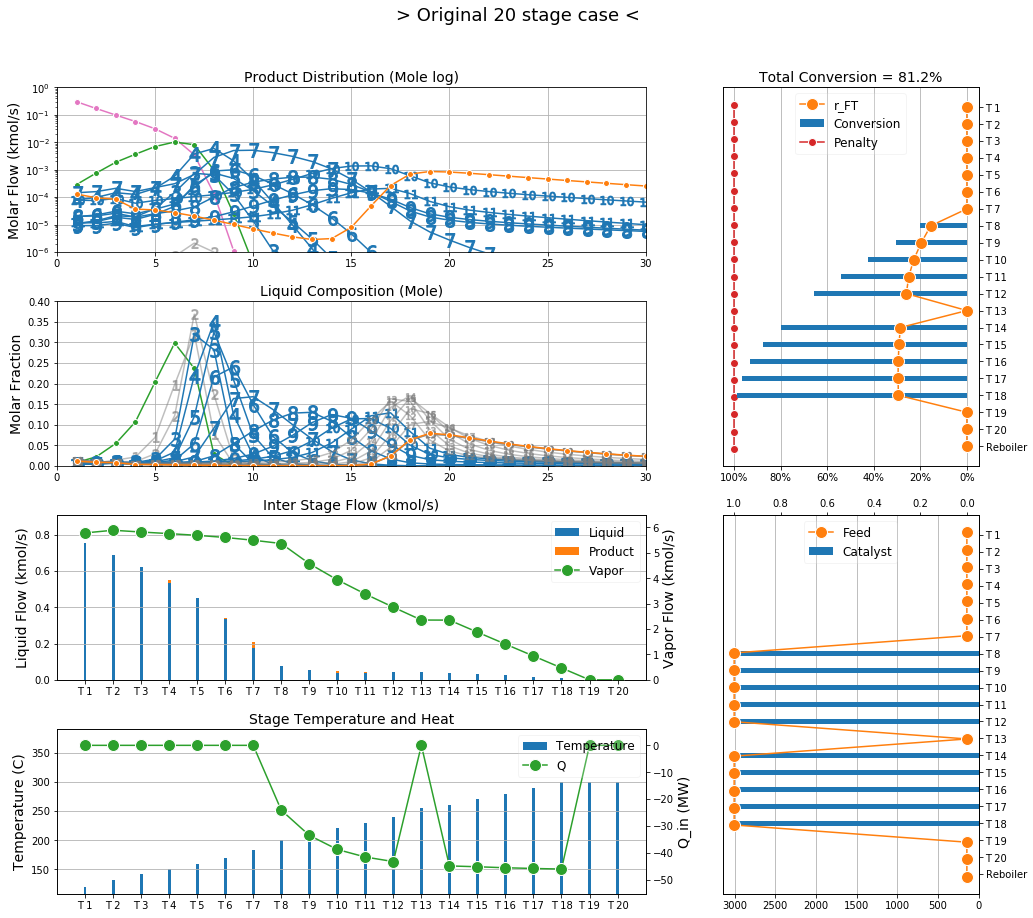

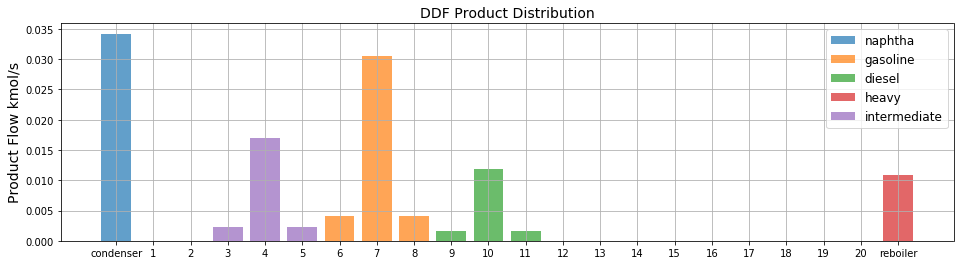

In [19]:
with HiddenLogs(log_text_dir,'w'):
    print('\n>','Original 20 stage case')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Original 20 stage case')
plot_product_distribution(model,pdf)

# Optimization

### Open up parameters

In [20]:
for j in model.TRAY_reactive:
    model.reactive[j].T.setlb(200+273.15)
    model.reactive[j].T.setub(300+273.15)
    
model.condenser.PR_L.unfix()
model.condenser.PR_L.setlb(0.05)
model.condenser.PR_L.setub(0.5)

model.P_total['intermediate'].unfix()
model.P_total['gasoline'].unfix()
model.P_total['diesel'].unfix()

### Constraints

In [21]:
model.quality_spec = pe.Param(m.PRODUCT,initialize={\
                    'naphtha':0.75,'gasoline':0.75,'diesel':0.6,'heavy':0.85},mutable=True)

def product_spec_rule(model,p):
    if p == 'intermediate':
        return pe.Constraint.Skip
    return sum(model.x_P_dry[i,p] for i in m.PRODUCT_cnumber[p]) >= model.quality_spec[p]
model.product_spec_con = pe.Constraint(m.PRODUCT,rule=product_spec_rule)

### Objective

In [22]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = model.P_total['gasoline'], sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> P_total[gasoline] - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [23]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
option_file_name=./ipopt.opt
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                              ma86_small = 1e-30                 yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
               mu_linear_decrease_factor = 0.6                   yes
           mu_superlinear_decrease_po


> Optimized Temperature, Reflux and Product Side Draw
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 85.67%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -148.                                        2.3031          0.6887  0.0937       2.3231

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     123.9  0.000       0.000  0.000  0.000  0.000       5.4087  0.0000  0.8126  0.0000       20.000
NON--[2]     134.9  0.000       0.000  0.000  0.000  0.000       5.5326  0.0000  0.7549  0.0000       20.000
NON--[3]     143.1  0.000       0.000  0.000  0.000  0.000       5.4749  0.0000  0.7106  0.0000       20.000
NON--[4]     150.1  0.00

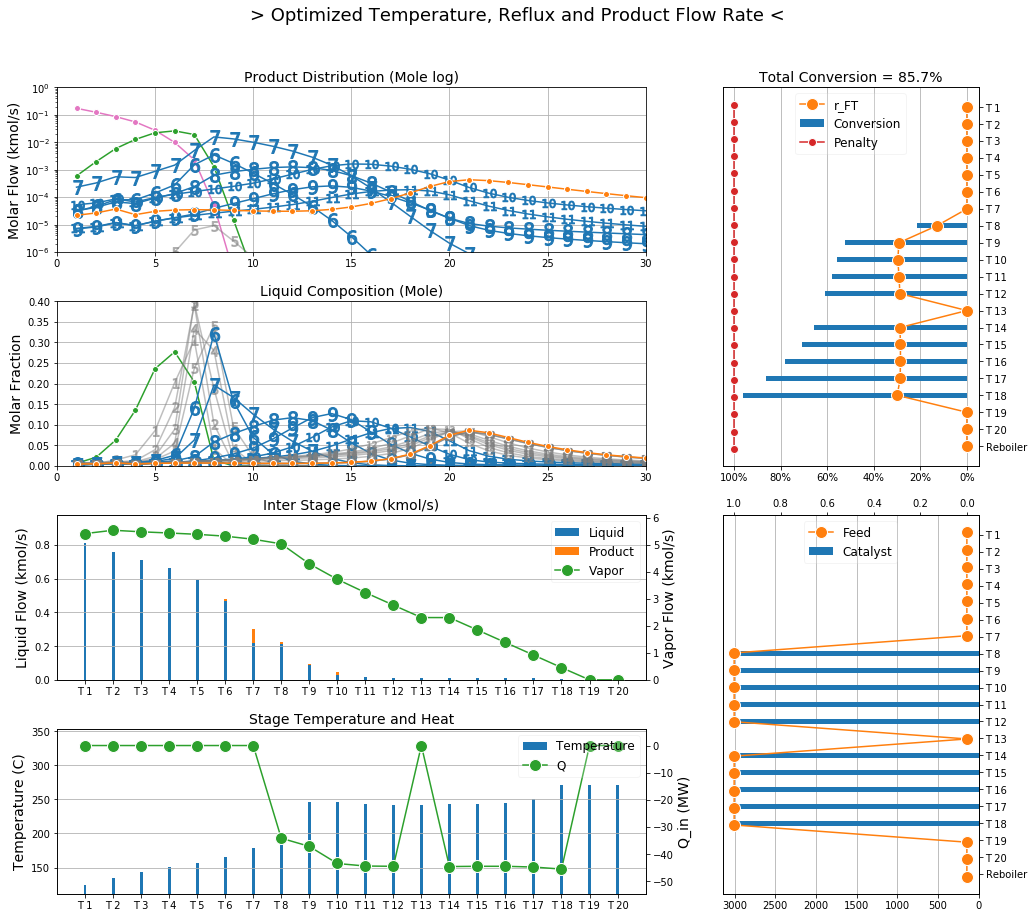

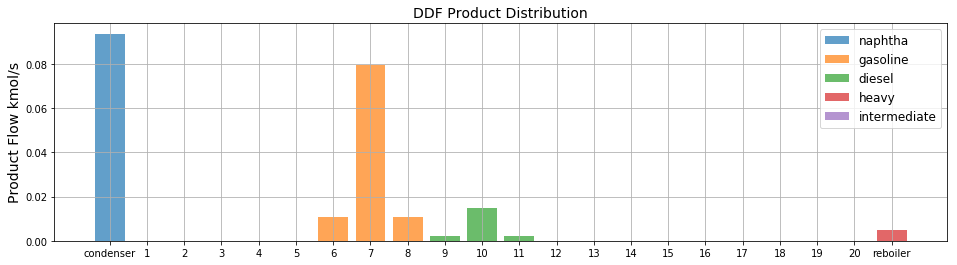

In [24]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Temperature, Reflux and Product Side Draw')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Temperature, Reflux and Product Flow Rate')
plot_product_distribution(model,pdf)

# Open up feed allocation

In [25]:
model.total_feed_con = pe.ConstraintList()
model.total_feed_con.add(expr = sum(model.reactive[j].F for j in model.reactive) == 10);

In [26]:
for j in model.reactive:
    model.reactive[j].F.unfix()
    model.reactive[j].F.setlb(0)
    model.reactive[j].F.setub(10)
    
# soft constraints to guide the feed allocation pattern
model.reactive[17].F.setlb(3)

In [27]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
option_file_name=./ipopt.opt
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                              ma86_small = 1e-30                 yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
               mu_linear_decrease_factor = 0.6                   yes
           mu_superlinear_decrease_po

  61 -1.1875603e-01 4.70e+00 7.92e+01  -6.0 1.45e+00  -2.8 5.76e-03 3.43e-02h  1
  62 -1.1875941e-01 4.52e+00 7.62e+01  -6.0 1.40e+00  -3.3 4.95e-02 3.92e-02h  1
  63 -1.1875460e-01 2.49e-04 7.37e+01  -6.0 1.35e+00  -3.8 5.38e-01 1.00e+00f  1
  64 -1.1876898e-01 8.79e-05 2.73e+01  -6.0 7.56e-02  -4.3 1.00e+00 6.47e-01h  1
  65 -1.1876704e-01 4.98e-07 5.03e-01  -6.0 1.32e-01  -4.8 1.00e+00 1.00e+00f  1
  66 -1.1879279e-01 7.76e-02 3.27e+00  -6.0 1.83e+03    -  1.26e-01 4.43e-02h  1
  67 -1.1879227e-01 7.56e-02 1.83e+01  -6.0 2.06e+01  -5.2 1.35e-01 2.69e-02h  1
  68 -1.1879463e-01 7.55e-02 1.83e+01  -6.0 3.99e+03    -  7.45e-05 3.22e-04h  2
  69 -1.1879465e-01 7.53e-02 1.80e+01  -6.0 8.19e+01  -4.8 6.40e-03 2.78e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.1880058e-01 2.08e-02 2.98e+00  -6.0 1.20e+00  -5.3 8.84e-01 7.24e-01h  1
  71 -1.1879747e-01 2.02e-02 1.42e+01  -6.0 1.27e+02    -  1.22e-02 3.19e-02f  1
  72 -1.1879754e-01 2.02e-02


> Optimized Feed Allocation
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 89.54%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -150.                                        1.8325          0.6304  0.0970       2.4241

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     125.4  0.000       0.000  0.000  0.000  0.000       4.9841  0.0000  0.7433  0.0000       20.000
NON--[2]     135.1  0.000       0.000  0.000  0.000  0.000       5.0970  0.0000  0.6890  0.0000       20.000
NON--[3]     142.9  0.000       0.000  0.000  0.000  0.000       5.0427  0.0000  0.6486  0.0000       20.000
NON--[4]     149.8  0.000       0.000  0.000  0.00

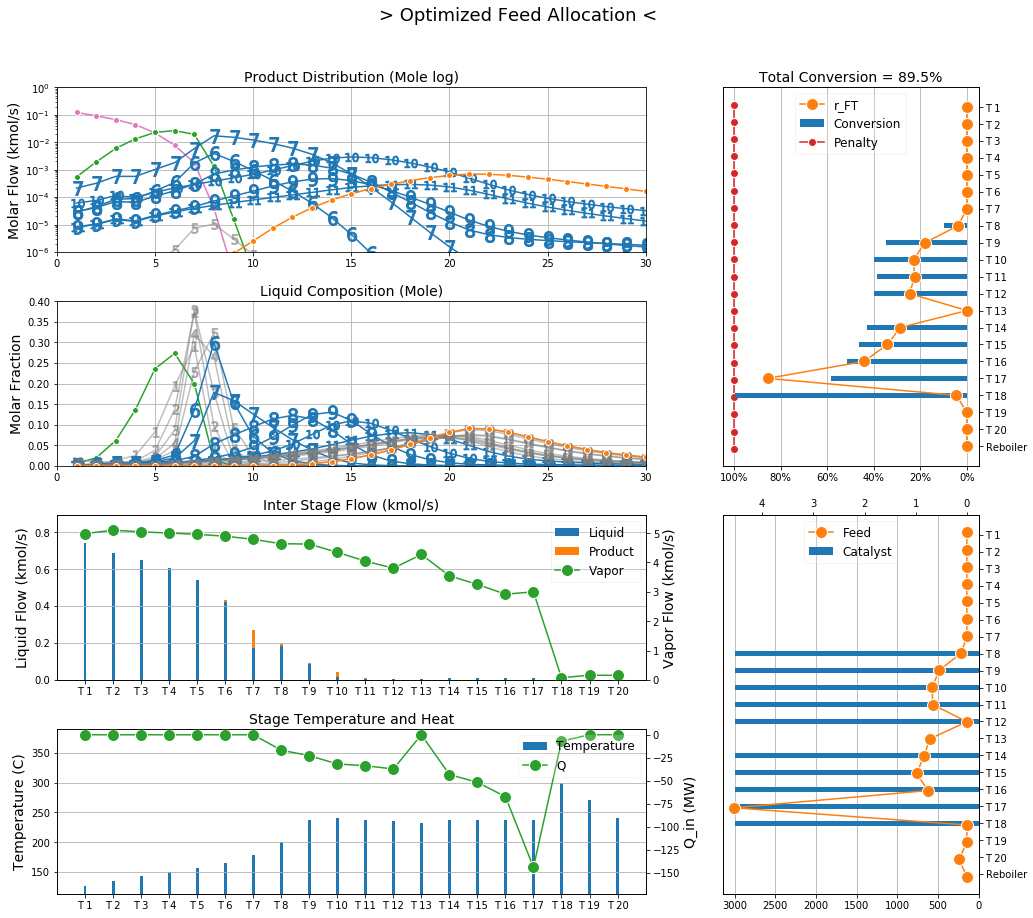

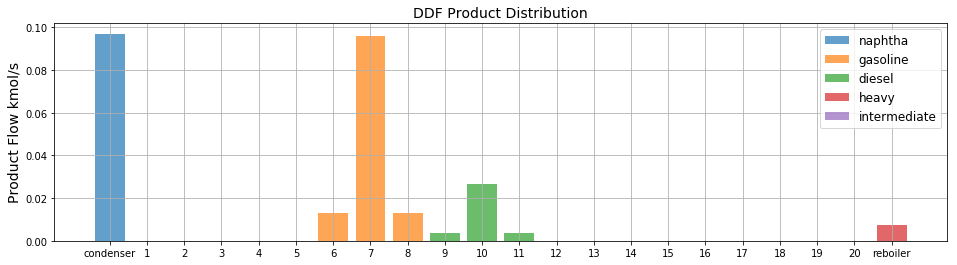

In [28]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Feed Allocation')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Feed Allocation')
plot_product_distribution(model,pdf)

# Open up catalyst allocation ( = TOTAL reconstruction, long wait time)

In [29]:
# for j in model.TRAY_reactive:
#     model.reactive[j].cat.unfix()
#     model.reactive[j].cat.setlb(10)
#     model.reactive[j].cat.setub(30000)

In [30]:
# model.total_cat_con = pe.ConstraintList()
# model.total_cat_con.add(expr = sum(model.reactive[j].cat for j in model.reactive) == 10*3000);

In [31]:
# results = opt.solve(model,tee=True)
# update_dual(pe,model)

In [32]:
# with HiddenLogs(log_text_dir):
#     print('\n>','Optimized Catalyst Amount and Location')
#     print('-'*108)
#     beautify(pe,model)
#     check_product_spec(model)
#     log_now()
#     check_iteration()

# plot_distribution(model,pdf,'Optimized Catalyst Amount and Location')
# plot_product_distribution(model,pdf)

# Use DDF,  open up gasoline location

In [33]:
model.N_tray['gasoline'].unfix();
model.N_tray['gasoline'].setlb(4)
model.N_tray['gasoline'].setub(10)

In [34]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
option_file_name=./ipopt.opt
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                              ma86_small = 1e-30                 yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
               mu_linear_decrease_factor = 0.6                   yes
           mu_superlinear_decrease_po


> Optimized Gasoline Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 89.46%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -146.                                        1.8300          0.5656  0.0914       2.4199

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     122.8  0.000       0.000  0.000  0.000  0.000       4.9071  0.0000  0.6543  0.0000       20.000
NON--[2]     131.5  0.000       0.000  0.000  0.000  0.000       4.9958  0.0000  0.5961  0.0000       20.000
NON--[3]     139.3  0.000       0.000  0.000  0.000  0.000       4.9375  0.0000  0.5468  0.0000       20.000
NON--[4]     147.2  0.000       0.000  0.000  0.

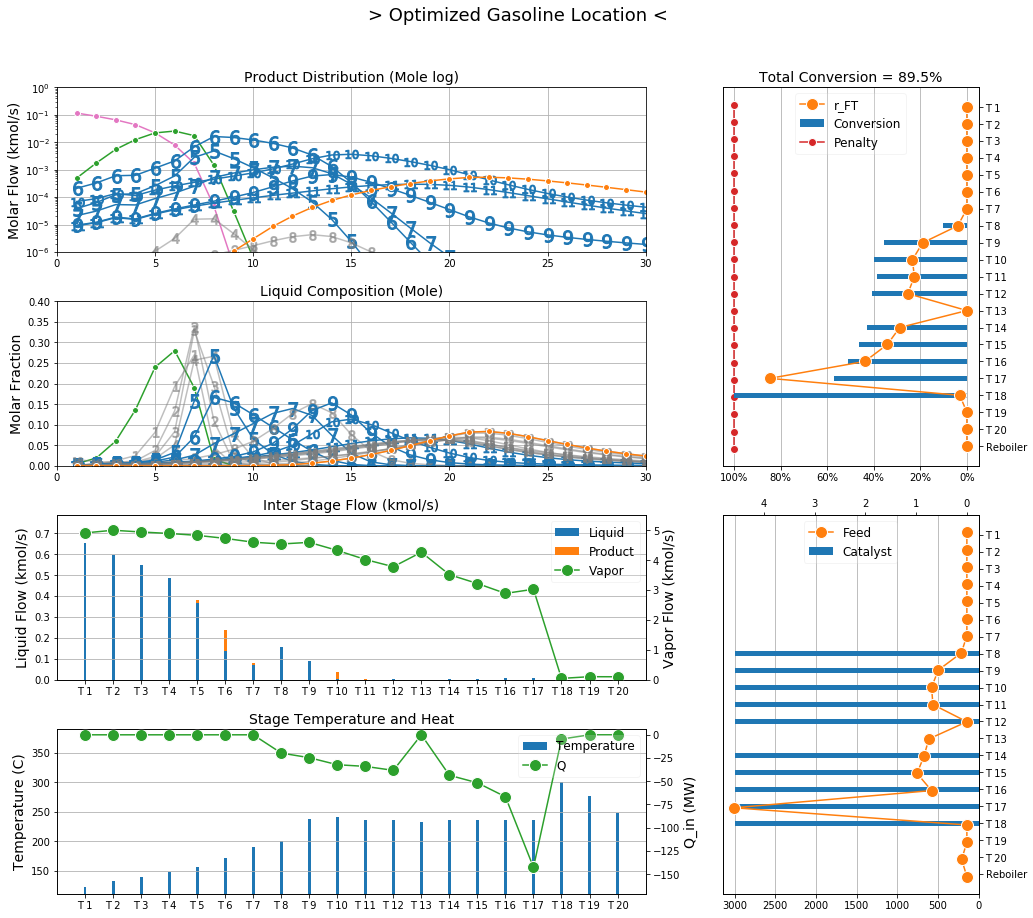

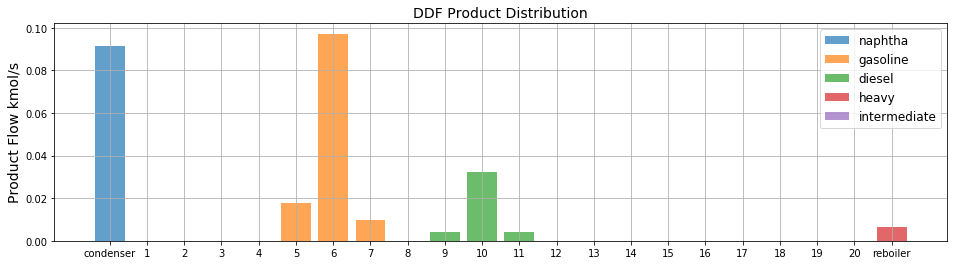

In [35]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Gasoline Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Gasoline Location')
plot_product_distribution(model,pdf)

In [36]:
model.N_tray['diesel'].unfix();
model.N_tray['diesel'].setlb(7)
model.N_tray['diesel'].setub(19)

In [39]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
option_file_name=./ipopt.opt
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                              ma86_small = 1e-30                 yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                        option_file_name = ./ipopt.opt           yes
                             output_f

  62 -1.2583697e-01 2.31e+01 9.34e+01  -6.0 5.20e+03  -8.2 1.63e-02 7.15e-02h  1
  63 -1.2586338e-01 2.26e+01 9.51e+01  -6.0 1.74e+03  -8.7 5.63e-05 2.03e-02h  2
  64 -1.2590681e-01 5.06e-02 8.30e+02  -6.0 5.01e+01  -7.4 1.61e-01 1.00e+00h  1
  65 -1.2591752e-01 5.09e-02 8.27e+02  -6.0 1.71e+03    -  3.18e-02 4.07e-03h  2
  66 -1.2594484e-01 6.14e-01 7.85e+02  -6.0 3.14e+03    -  9.60e-01 5.13e-02h  1
  67 -1.2604218e-01 1.91e+00 1.63e+02  -6.0 2.35e+02    -  5.95e-01 9.73e-01h  1
  68 -1.2610940e-01 3.23e-01 2.30e+01  -6.0 9.73e+01    -  9.41e-01 8.60e-01h  1
  69 -1.2612596e-01 1.38e+00 9.77e+01  -6.0 5.37e+02    -  4.67e-01 3.77e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.2611527e-01 6.70e-01 1.98e+02  -6.0 8.72e+04    -  7.73e-03 9.13e-04h  2
  71 -1.2609600e-01 1.87e+00 8.96e+02  -6.0 1.64e+03    -  6.55e-01 2.03e-01h  1
  72 -1.2615660e-01 1.58e+00 2.24e+02  -6.0 4.13e+02    -  7.40e-01 7.37e-01h  1
  73 -1.2624585e-01 1.48e+00

 155 -1.2905176e-01 1.50e+00 2.46e+04  -9.0 2.30e+01  -8.6 1.39e-02 2.94e-01h  1
 156 -1.2902883e-01 5.28e-02 8.93e+01  -9.0 3.58e+01  -9.1 3.01e-05 1.00e+00h  1
 157 -1.2906580e-01 3.18e-02 3.38e+01  -9.0 3.92e+01    -  1.00e+00 6.43e-01h  1
 158 -1.2912535e-01 1.84e-02 1.25e+01  -9.0 4.55e+01    -  3.19e-01 6.58e-01h  1
 159 -1.2920587e-01 3.96e-02 6.97e-01  -9.0 5.20e+01    -  9.06e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 -1.2921446e-01 3.98e-02 3.44e+00  -9.0 2.02e+02    -  2.96e-01 8.29e-02h  1
 161 -1.2930839e-01 4.84e-01 1.41e+01  -9.0 1.83e+02    -  7.66e-02 1.00e+00h  1
 162 -1.2931882e-01 5.29e-01 8.20e+00  -9.0 7.72e+02    -  3.99e-01 1.06e-01h  1
Scaling factors are invalid - setting them all to 1.
 163 -1.2941560e-01 7.15e+00 5.04e+01  -9.0 7.07e+02    -  1.10e-01 1.00e+00h  1
 164 -1.2943296e-01 6.20e+00 6.25e+01  -9.0 8.91e+02    -  9.24e-02 2.01e-01h  1
Scaling factors are invalid - setting them all to 1.
 16

Scaling factors are invalid - setting them all to 1.
 239 -1.3253715e-01 5.83e+01 7.22e+01  -9.0 6.15e+04    -  2.61e-06 1.24e-04h  1
Scaling factors are invalid - setting them all to 1.
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 -1.3282996e-01 5.79e+01 7.16e+01  -9.0 6.08e+04    -  4.27e-03 7.08e-03h  1
Scaling factors are invalid - setting them all to 1.
 241 -1.3288600e-01 5.76e+01 7.13e+01  -9.0 1.78e+04    -  9.25e-03 4.82e-03h  1
Scaling factors are invalid - setting them all to 1.
 242 -1.3289822e-01 5.74e+01 7.09e+01  -9.0 6.99e+03    -  6.00e-02 4.57e-03h  1
Scaling factors are invalid - setting them all to 1.
 243 -1.3291284e-01 5.63e+01 6.98e+01  -9.0 3.56e+03    -  5.91e-02 1.81e-02h  1
Scaling factors are invalid - setting them all to 1.
 244 -1.3292242e-01 5.42e+01 6.70e+01  -9.0 3.20e+03    -  8.11e-02 3.90e-02h  1
Scaling factors are invalid - setting them all to 1.
 245 -1.3291980e-01 4.67e+01 5.68e+01  -9.0 1.26e+03    -  5.5

Scaling factors are invalid - setting them all to 1.
 307 -1.3195269e-01 3.77e+01 2.82e-01  -9.0 4.31e+03    -  4.20e-01 3.46e-01h  1
Scaling factors are invalid - setting them all to 1.
 308 -1.3195296e-01 3.91e+01 4.22e-01  -9.0 3.45e+03    -  1.00e+00 3.42e-01H  1
Scaling factors are invalid - setting them all to 1.
 309 -1.3195351e-01 1.12e+02 7.87e-01  -9.0 9.36e+03    -  4.65e-02 5.71e-02H  1
Scaling factors are invalid - setting them all to 1.
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310 -1.3195402e-01 3.58e+00 8.41e+00  -9.0 6.35e+02    -  7.63e-01 1.00e+00h  1
Scaling factors are invalid - setting them all to 1.
 311 -1.3195409e-01 3.55e+00 8.11e+00  -9.0 2.75e+03    -  3.91e-01 3.64e-02h  1
Scaling factors are invalid - setting them all to 1.
 312 -1.3195440e-01 1.12e+01 1.16e+00  -9.0 9.38e+02    -  1.00e+00 1.00e+00h  1
Scaling factors are invalid - setting them all to 1.
Scaling factors are invalid - setting them all to 1.
 313 -1.3

ApplicationError: Solver (ipopt) did not exit normally

In [ ]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Diesel Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Diesel Location')
plot_product_distribution(model,pdf)

In [ ]:
pdf.close()

In [ ]:
# with open('./log/model/{}.pickle'.format(logname),'wb') as f:
#     dill.dump(model,f)